# **Data Analysis Pima Indians Diabetes**
-------

Dataset ini berasal dari Institut Nasional Diabetes dan Penyakit Pencernaan dan Ginjal. Tujuan dari kumpulan data ini adalah untuk memprediksi secara diagnostik apakah pasien menderita diabetes atau tidak, berdasarkan pengukuran diagnostik tertentu yang disertakan dalam kumpulan data. Beberapa batasan ditempatkan pada pemilihan contoh-contoh ini dari basis data yang lebih besar. Secara khusus, semua pasien di sini adalah perempuan berusia minimal 21 tahun yang berasal dari suku **Indian Pima**.

## Libraries

In [262]:
# untuk kalkulasi dan manipulasi data
import pandas as pd
import numpy as np

# untuk visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# untuk sampling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

# untuk modelling
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, learning_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# untuk evaluation
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, precision_recall_curve, average_precision_score, auc

In [263]:
import warnings
warnings.filterwarnings("ignore")

## Data load

In [264]:
# load the data
df = pd.read_csv('D:\Project Data Analysis\Data & src code\Pima Indians Diabetes Database\data\diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Feature Engineering

In [265]:
# melakukan klasifikasi diabetes dari outcome

def classify_outcome(outcome):
    if outcome == 0:
        return "Tidak Diabetes"
    else:
        return "Diabetes"
    
# Memasukkan hasil decoding
df['Category_outcome'] = df['Outcome'].apply(classify_outcome)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Category_outcome
0,6,148,72,35,0,33.6,0.627,50,1,Diabetes
1,1,85,66,29,0,26.6,0.351,31,0,Tidak Diabetes
2,8,183,64,0,0,23.3,0.672,32,1,Diabetes
3,1,89,66,23,94,28.1,0.167,21,0,Tidak Diabetes
4,0,137,40,35,168,43.1,2.288,33,1,Diabetes
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,Tidak Diabetes
764,2,122,70,27,0,36.8,0.340,27,0,Tidak Diabetes
765,5,121,72,23,112,26.2,0.245,30,0,Tidak Diabetes
766,1,126,60,0,0,30.1,0.349,47,1,Diabetes


## Data Understanding

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   Category_outcome          768 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 60.1+ KB


**Dimensi Data**

Data terdiri dari **768 baris dan 9 fitur**

In [267]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [268]:
df[['Category_outcome']].value_counts()

Category_outcome
Tidak Diabetes      500
Diabetes            268
dtype: int64

In [269]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Category_outcome            0
dtype: int64

## Exploratory Data Anlysis (EDA)

### Univatiate Anlaysis

#### Correlation

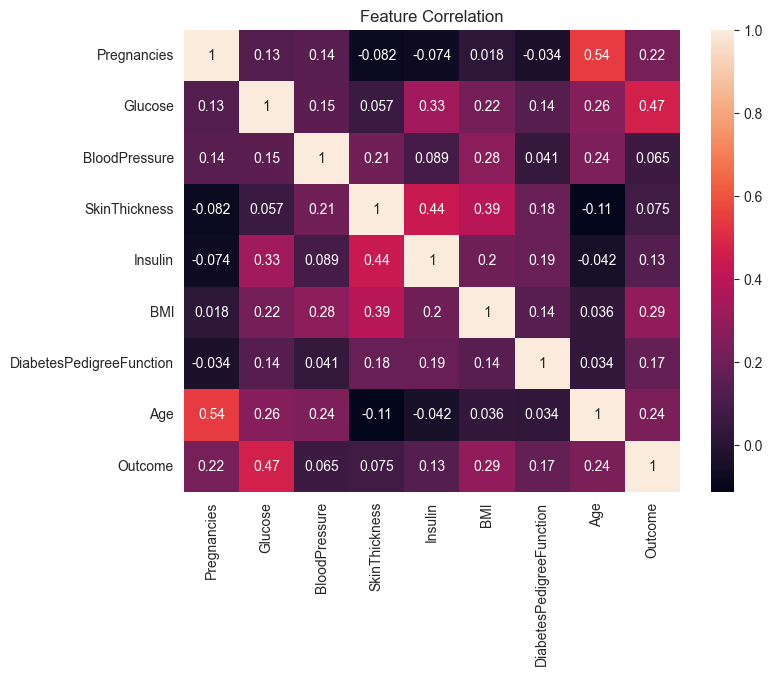

In [270]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap='rocket',  annot=True)
plt.title('Feature Correlation')
plt.show()

<Figure size 1200x600 with 0 Axes>

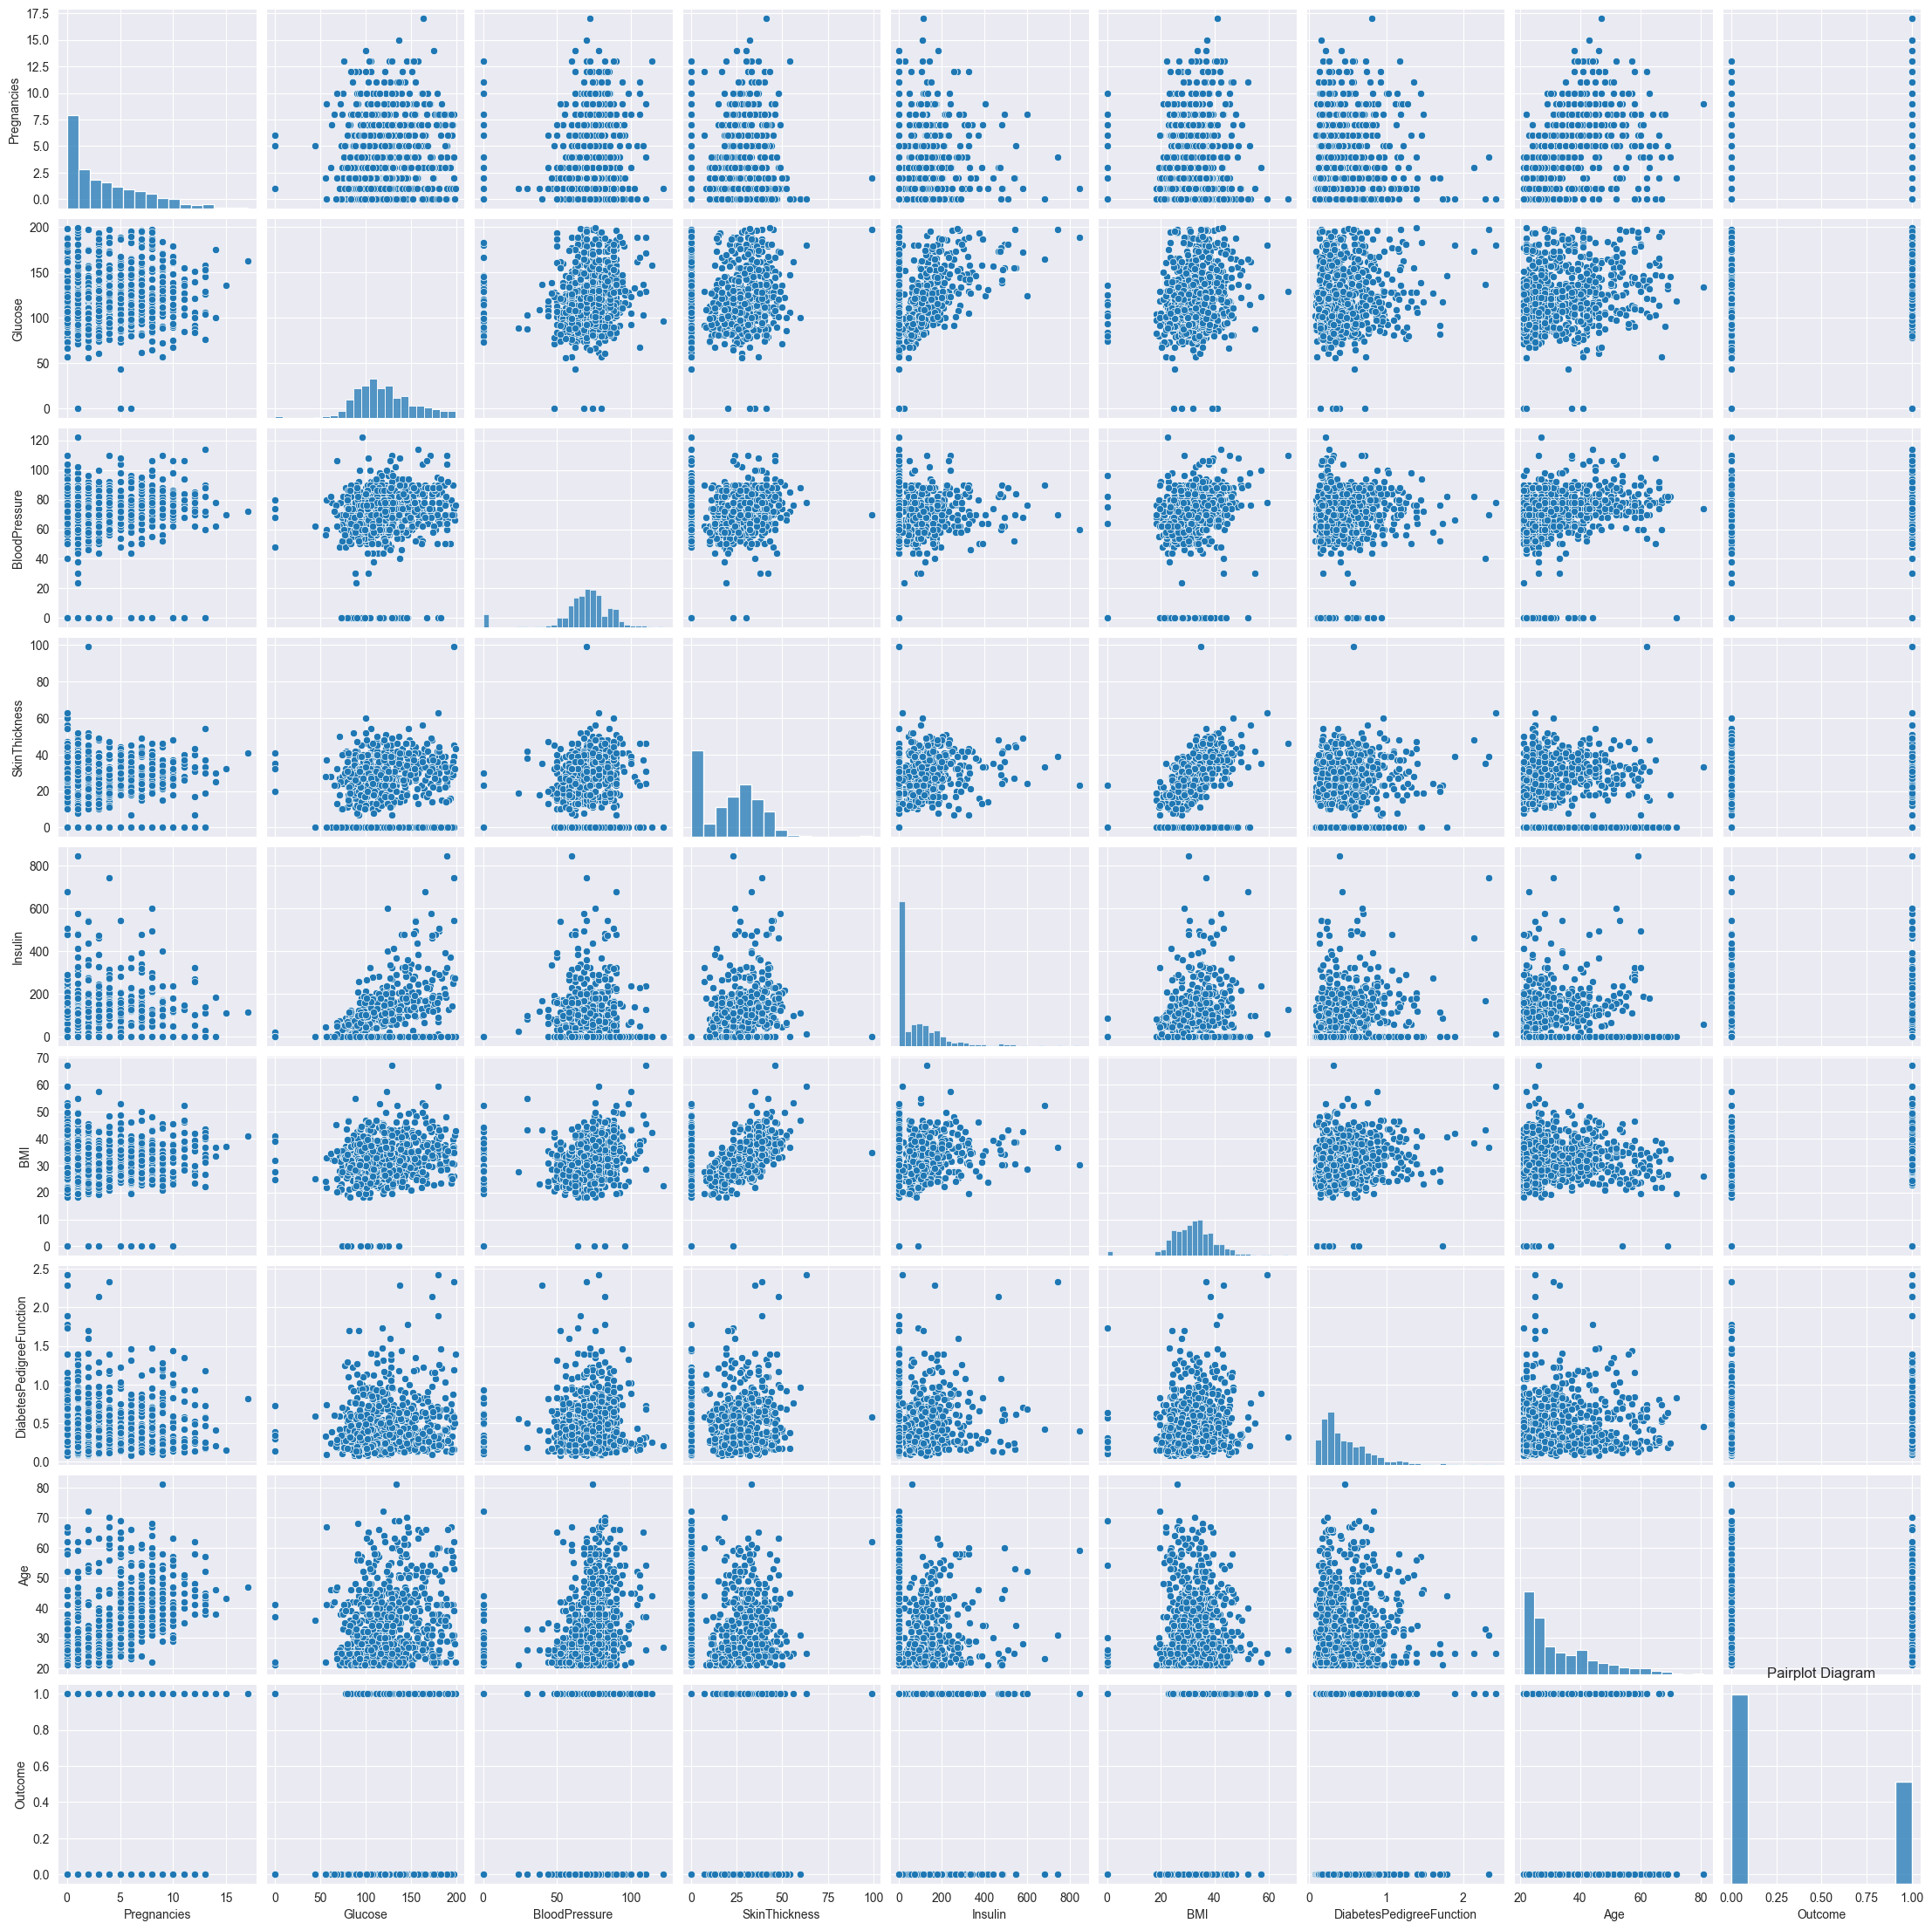

In [271]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))

sns.pairplot(df, diag_kind='hist')
plt.title('Pairplot Diagram')
plt.show()

Bila dilihat pada grafik histogram didalam pairplot, terdapat data **outlier** yang perlu kita check kembali kebenarannya.

Jika diperhatikan beberapa data **outlier** terlihat pada fitur **Glucose, BloodPressure, dan BMI**. Data oulier dari ketiga fitur tersebut memiliki nilai 0 yang mana nilai ini tidak mungkin terjadi pada pemerikasaan darah pada manusia yang masih hidup. Sehingga masuk akal jika data ini terjadi karena kesalahan input atau dalam pemriksaan pengecekan ketiga fitur tersebut pada suatu individu tidak dilakukan.

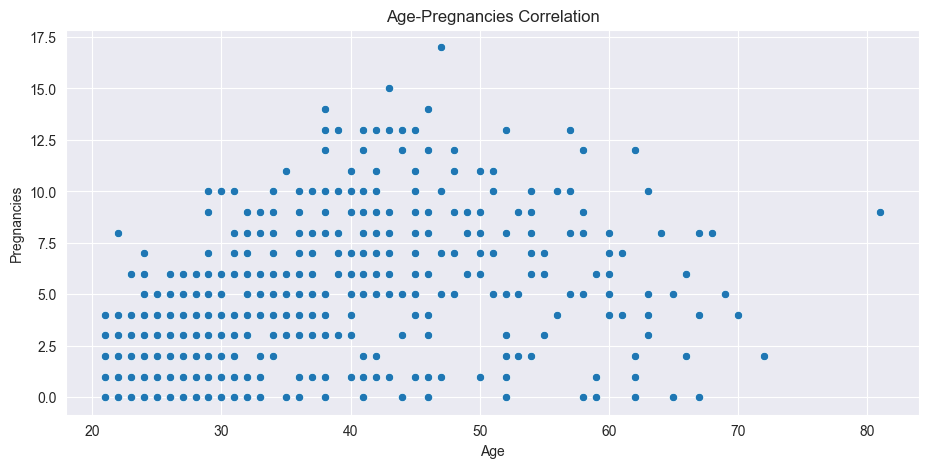

In [272]:
plt.figure(figsize=(11,5))


sns.scatterplot(x=df['Age'], y=df['Pregnancies'])
plt.title('Age-Pregnancies Correlation')
plt.show()

**Semakin Bertamabah Usia, Angka Kelahmilan Semakin Meningkat?**

Melihat dari nilai korelasi, fitur Age dan Pregnancies memiliki korelasi kuat. Hal ini dapat dipahami jika kita melihat bahwa semakin bertambahnya umur potensi besarnya kelahiran juga semakin meningkat terutama jika melihat di negara India yang merupakan negara ke-2 dengan populasi terbanyak dan peningkatan populasi yang masif di 10 tahun terakhir.

#### Distribution

##### **Pregnancies**

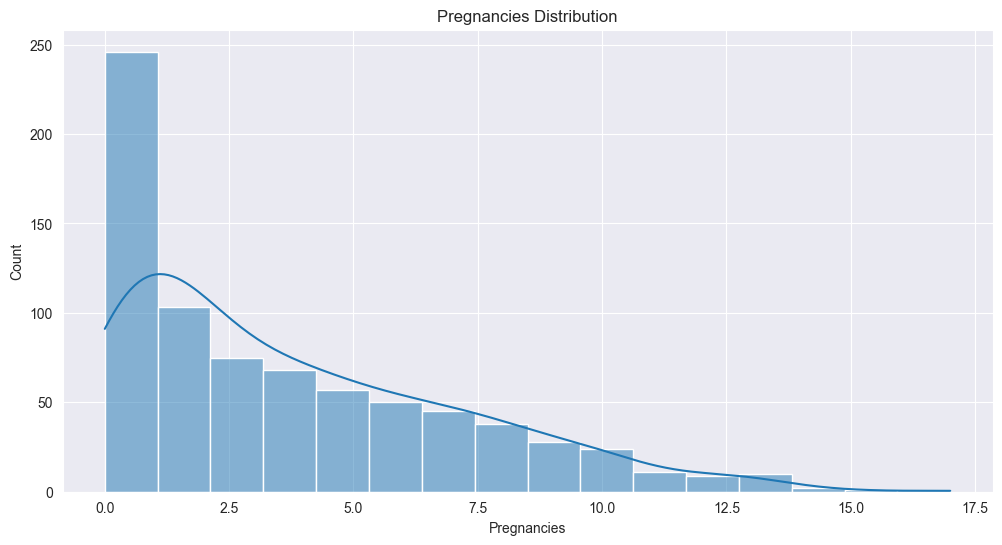

In [273]:
plt.figure(figsize=(12,6))

sns.histplot(df['Pregnancies'], kde=True)
plt.title('Pregnancies Distribution')
plt.show()

##### **Age**

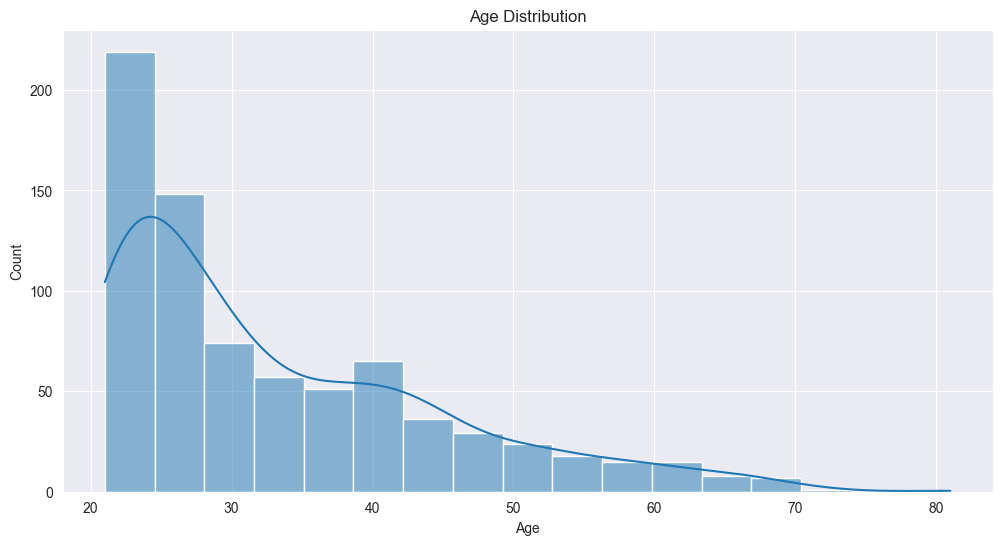

In [274]:
plt.figure(figsize=(12,6))

sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

**Mayoritas Umur?**

Dari sebaran data dapat diketahui bahwa umur berada pada rentang 20-80 tahun, dengan mayoritas data berada pada umur 21-30 tahun.

##### **Glucose**

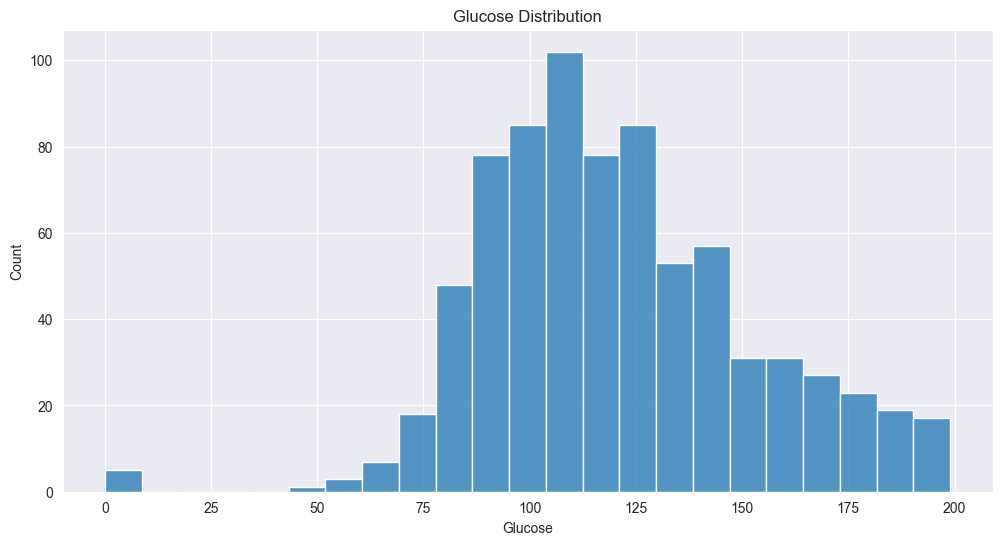

In [275]:
plt.figure(figsize=(12,6))

sns.histplot(df['Glucose'])
plt.title('Glucose Distribution')
plt.show()

**Konsentrasi glukosa dalam plasma darah yang diambil dari Tes Toleransi Glukosa Oral (TTGO)**

Tes Toleransi Glukosa Oral (**TTGO**) adalah tes untuk mengukur kemampuan tubuh dalam menggunakan glukosa. Tes ini dapat digunakan untuk mendeteksi diabetes, pradiabetes, dan diabetes gestasional.

Tes ini dilakukan pada paisen dengan tata cara paisen berpuasa selama 8-12 jam,  kemudian diberikan larutan glukosa, dan diukur kadar glukosa dalam darah setelah 2 jam.

Seperti yang disebutkan sebelumnya terdapat nilai outlier 0 yang mungkin mengalami kesalahan dalam input atau pemeriksaan sehingga perlu dilakukan **cleaning** pada data outlier untuk menjaga keseimbangan data.

**Interpertasi kadar glukosa dalam darah setelah 2 jam (Sesuai panduan WHO)**

1. **< 140 mg/dL** = normal
2. **140 - 199 mg/dL** = prediabetes (Glukosa Terganggu)
3. **\> 200 mg/dL** = Diabetes

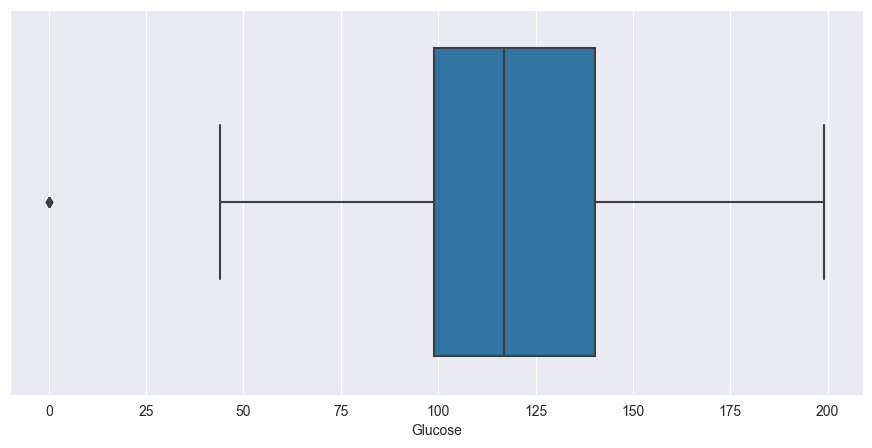

In [276]:
plt.figure(figsize=(11,5))
sns.boxplot(data=df, x='Glucose')
plt.show()

In [277]:
# melakukan klasifikasi glukosa dalam tubuh

def classify_glucose(glucose):
    if glucose < 140:
        return "Normal"
    elif  140 <= glucose <= 199:
        return "Prediabetes"
    else :
        return "Diabetes"
# Memasukkan hasil decoding
df['Category_glucose'] = df['Glucose'].apply(classify_glucose)
df['Category_glucose'].value_counts()

Normal         571
Prediabetes    197
Name: Category_glucose, dtype: int64

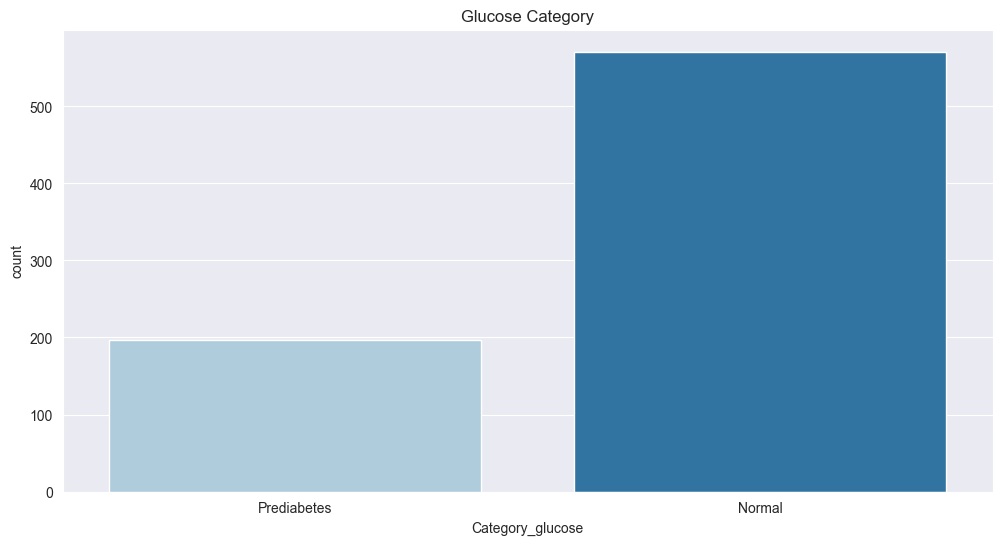

In [278]:
plt.figure(figsize=(12,6))

sns.countplot(df, x='Category_glucose', palette='Paired')
plt.title('Glucose Category')
plt.show()

##### **BMI (Body Mass Index)**

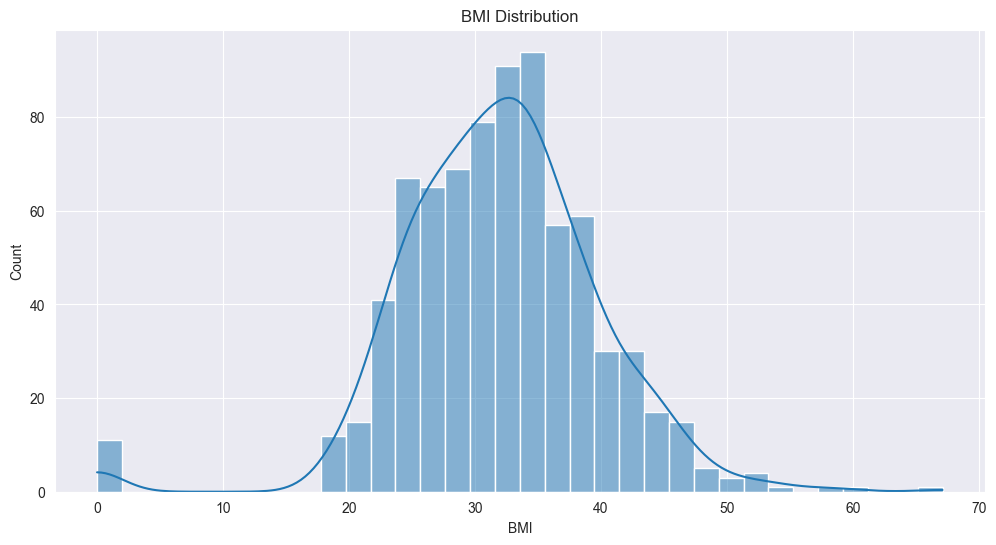

In [279]:
plt.figure(figsize=(12,6))

sns.histplot(df['BMI'], kde=True)
plt.title('BMI Distribution')
plt.show()

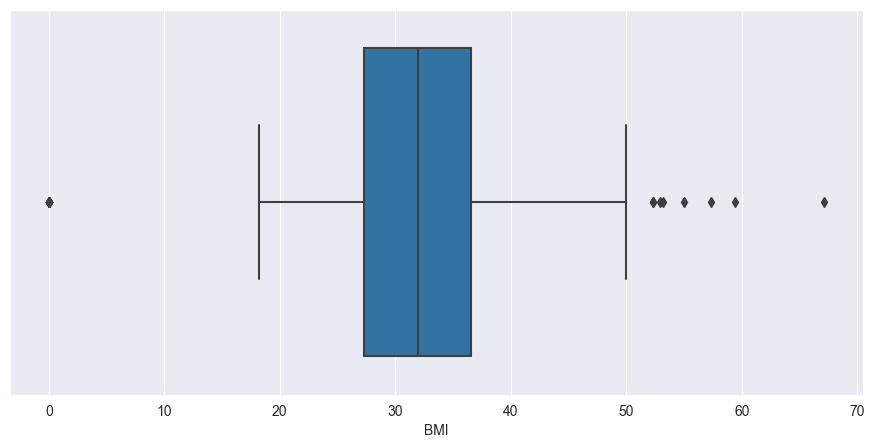

In [280]:
plt.figure(figsize=(11,5))
sns.boxplot(data=df, x='BMI')
plt.show()

**Apa itu BMI?**

**BMI** merupakan indikator untuk menentukan kategori berat badan seseorang.

.
.
.

**Interpertasi nilai BMI (berdasarkan WHO)**

Berdasarkan WHO berikut adalah nilai interpertasi untuk BMI: 
1. **< 18,5** = Berat badan kurang proporsional
2. **18,5 – 22,9** = Berat badan ideal
3. **23 – 29,9** = Berat badan berlebih (berpotensi obesitas)
4. **\> 30** = Obesitas

Nilai ini akan digunakan untuk melakukan **klasifikasi** agar memudahkan dalam melakuan labeling pada suatu fitur dan juga memudahkan dalam melakukan pemodelan nanti. 

Sama seperti yang telah disebutkan sebelumnya, fitur BMI memiliki data outlier yang perlu dihapus agar tidak mengganggu keseimbangan data.

In [281]:
# melakukan klasifikasi BMI 

def classify_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif  18.5 <= bmi <= 24.9:
        return "Ideal"
    elif 25 <= bmi <= 29.9:
        return "Overweight"
    else:
        return "Obese"
# Memasukkan hasil decoding
df['Category_bmi'] = df['BMI'].apply(classify_bmi)
df['Category_bmi'].value_counts()

Obese          472
Overweight     179
Ideal          102
Underweight     15
Name: Category_bmi, dtype: int64

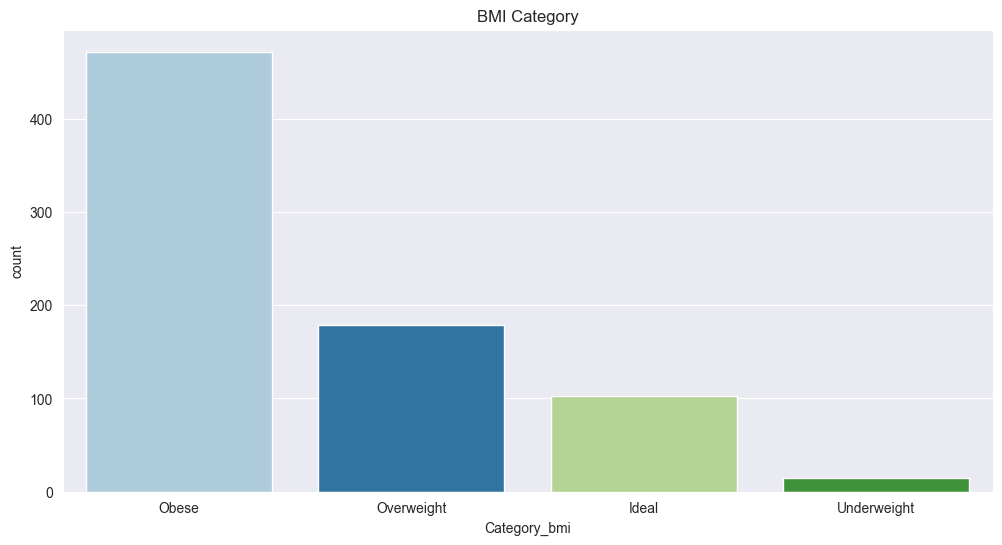

In [282]:
plt.figure(figsize=(12,6))

sns.countplot(df, x='Category_bmi', palette='Paired')
plt.title('BMI Category')
plt.show()

##### **Skin Thickness**

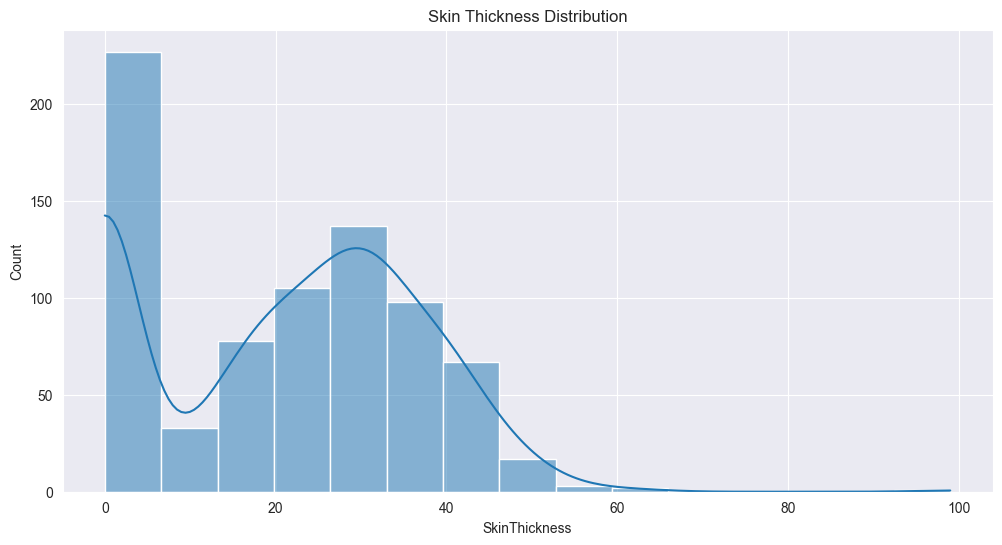

In [283]:
plt.figure(figsize=(12,6))

sns.histplot(df['SkinThickness'], kde=True)
plt.title('Skin Thickness Distribution')
plt.show()

**Skin Thickness?**

Fitur **SkinThickness** dalam data ini merujuk pada ketebalan lipatan kulit di area triceps (otot lengan atas) yang diukur dalam milimeter (mm). Ini biasanya diukur menggunakan alat khusus yang disebut caliper.

**Triceps skin fold thickness** adalah ukuran ketebalan lipatan lemak subkutan di bawah kulit pada lengan atas (triceps), yang mencerminkan seberapa banyak lemak tubuh yang ada di area tersebut.

**Hal yang perlu dipahami kaitannya dengan fitur lain**

- **Hubungan dengan Resistensi Insulin**

    Lemak tubuh berlebih, terutama lemak visceral (di sekitar organ), dapat menyebabkan resistensi insulin yang merupakan faktor utama dalam pengembangan diabetes tipe 2.


- **Penilaian Kesehatan Metabolik**

    Mengukur ketebalan lipatan kulit dapat memberikan informasi tambahan tentang kesehatan metabolik seseorang.
    Ketebalan kulit yang lebih tebal cenderung terkait dengan tingkat **risiko lebih tinggi** untuk penyakit metabolik seperti **diabetes**, meskipun tidak secara langsung menentukan.

- **Perkiraan Risiko Obesitas**

    Ketebalan lipatan kulit, termasuk triceps, sering digunakan dalam formula untuk menghitung persentase lemak tubuh. Obesitas adalah faktor risiko utama untuk diabetes tipe 2, jadi informasi ini penting dalam mendiagnosis atau memantau risiko diabetes.

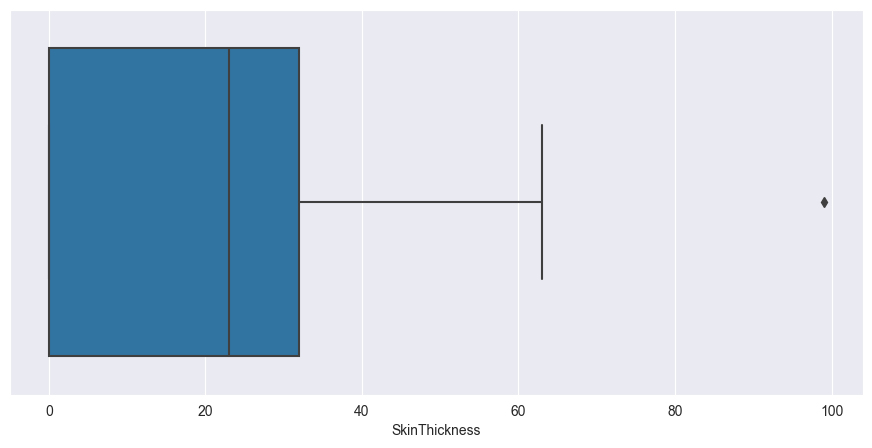

In [284]:
plt.figure(figsize=(11,5))
sns.boxplot(data=df, x='SkinThickness')
plt.show()

In [285]:
# menghapus data oulier dengan nilai ekstrem
df = df[df['SkinThickness'] != 99]

##### **Blood Pressure**

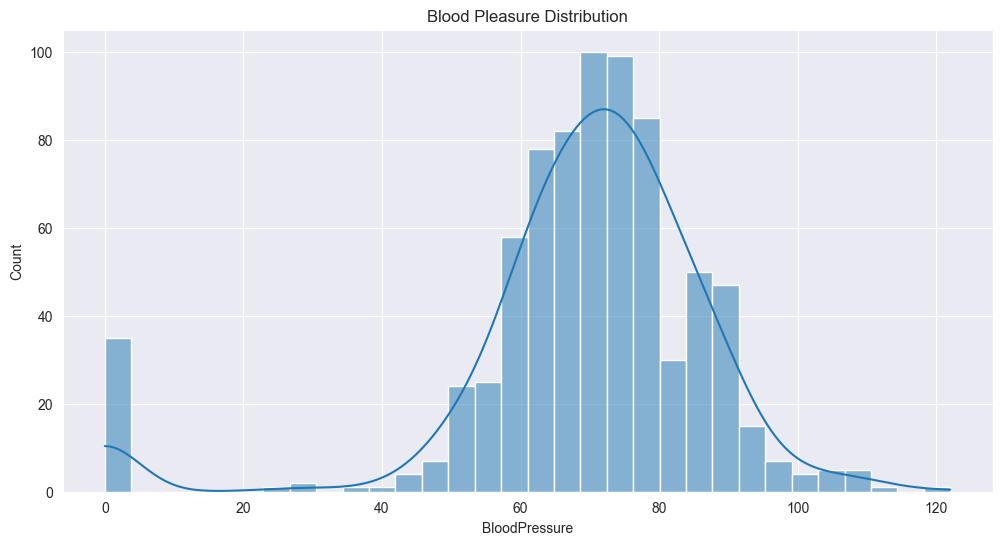

In [286]:
plt.figure(figsize=(12,6))

sns.histplot(df['BloodPressure'], kde=True)
plt.title('Blood Pleasure Distribution')
plt.show()

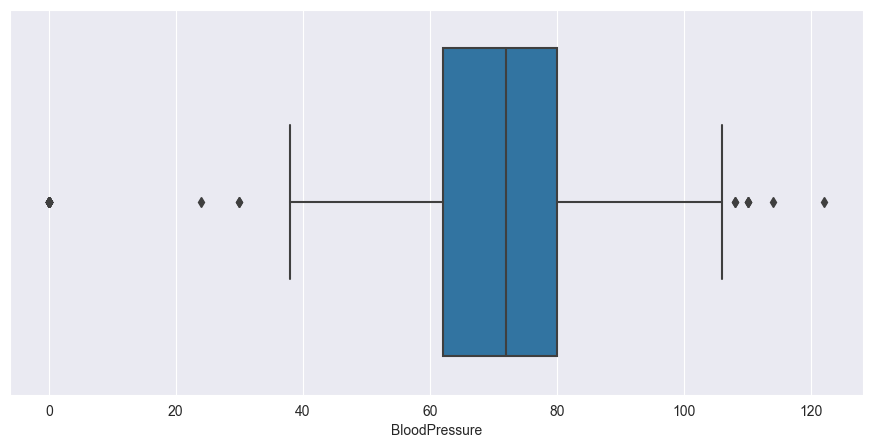

In [287]:
plt.figure(figsize=(11,5))
sns.boxplot(data=df, x='BloodPressure')
plt.show()

##### **Diabetes Pedigree Function**

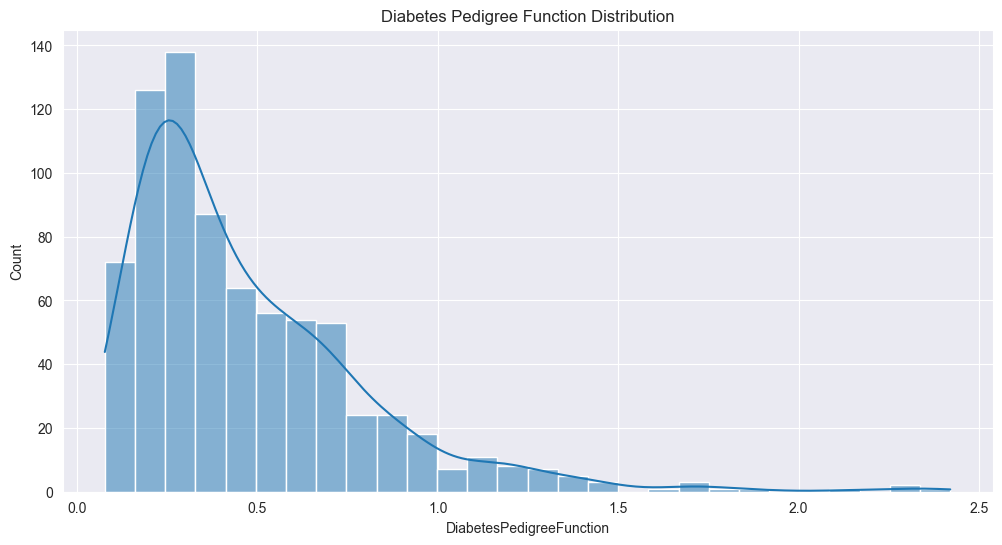

In [288]:
plt.figure(figsize=(12,6))

sns.histplot(df['DiabetesPedigreeFunction'], kde=True)
plt.title('Diabetes Pedigree Function Distribution')
plt.show()

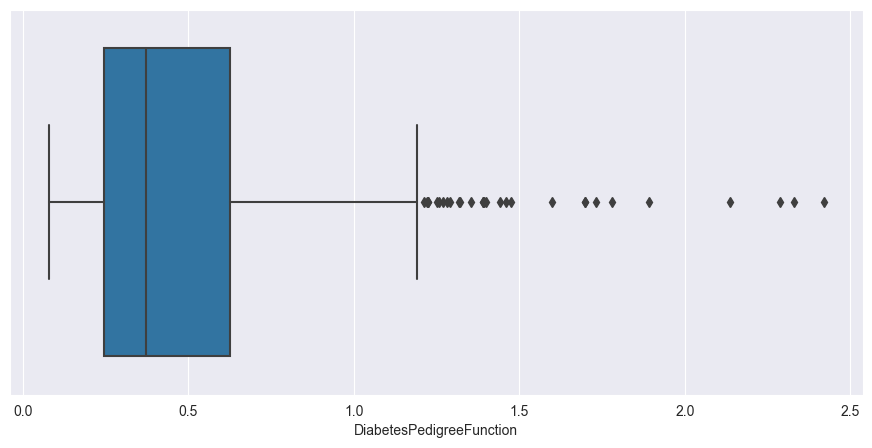

In [289]:
plt.figure(figsize=(11,5))
sns.boxplot(data=df, x='DiabetesPedigreeFunction')
plt.show()

In [290]:
df['DiabetesPedigreeFunction'].describe()

count    767.000000
mean       0.471742
std        0.331524
min        0.078000
25%        0.243500
50%        0.371000
75%        0.626500
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

**Apa itu Diabetes Pedigree Function?**

Diabetes Pedegriee Function (**DPF**) merupakan ukuran nilai yang diberikan untuk memnunjukkan seberapa besar faktor keturunan diabetes dalam keluarga seseorang.

**Apa yang bisa dipahami dari nilai DPF?**

Nilai ini diberikan dengan menghitung riwayat diabetes berdasarkan sejarah dan hubungan dari genetik. Semakin besar nilai DPF, semakin besar pula kemungkinan seseorang memiliki riwayat keluarga dengan diabetes. Nilai ini bukan sekadar jumlah anggota keluarga dengan diabetes, tetapi juga mempertimbangkan seberapa dekat hubungan kekerabatan mereka (misalnya, orang tua dengan diabetes memberi kontribusi lebih besar dibanding sepupu).

Dari nilai fitur DPF pada data ini  interpertasi nilai DPF bisa kita pahami sebagai berikut:
1. **< 0.3** = risiko rendah, sedikit atau tidak ada riwayat keluarga diabetes
2. **0.3 - 0.7** = risiko sedang, ada riwayat keluarga diabetes
3. **0.8 - 1.0** = risiko tinggi, banyak terdaapat riwayat keluarga diabetes
4. **\> 2.0** = risiko sangat tinggi, kemungkinan besar berasal dari keluarga dengan sejarah diabetes kuat

In [291]:
# melakukan klasifikasi glukosa dalam tubuh

def classify_dpf(dpf):
    if dpf < 0.3:
        return "Rendah"
    elif  0.3 <= dpf <= 0.7:
        return "Sedang"
    elif  0.8 <= dpf <= 1.0:
        return "Tinggi"
    else :
        return "Sangat Tinggi"
    
# Memasukkan hasil decoding
df['Category_dpf'] = df['DiabetesPedigreeFunction'].apply(classify_dpf)
df['Category_dpf'].value_counts()

Sedang           319
Rendah           304
Sangat Tinggi     90
Tinggi            54
Name: Category_dpf, dtype: int64

##### **Insulin**

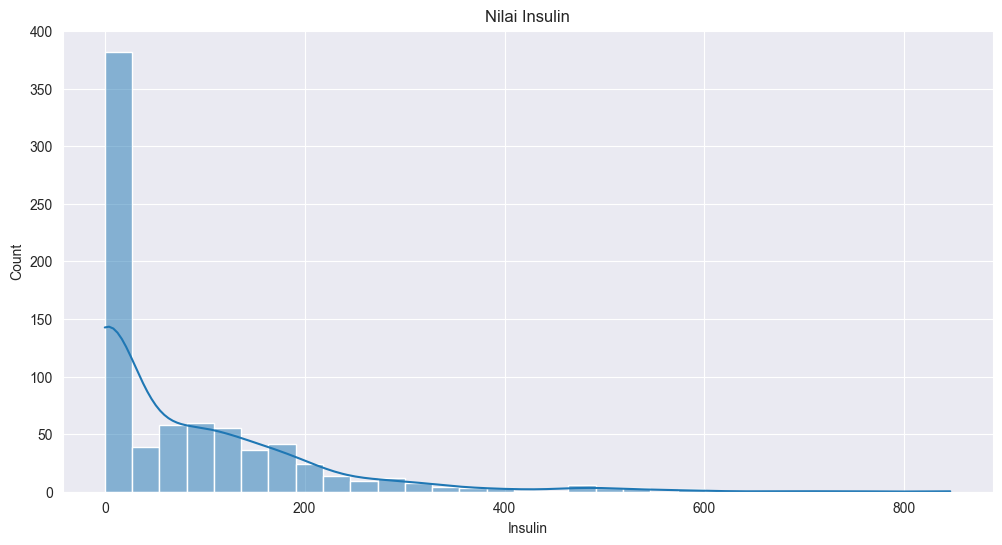

In [292]:
plt.figure(figsize=(12,6))

sns.histplot(df['Insulin'], kde=True)
plt.title('Nilai Insulin')
plt.show()

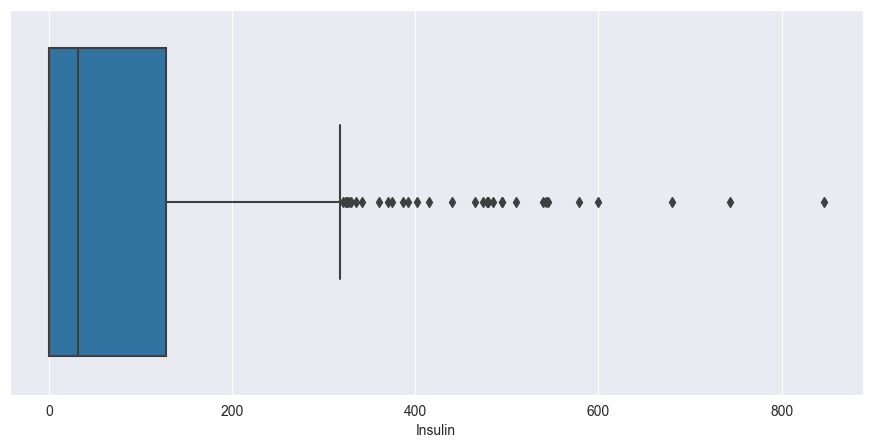

In [293]:
plt.figure(figsize=(11,5))
sns.boxplot(data=df, x='Insulin')
plt.show()

**Apa itu Inuslin?**

Fitur **Insulin** merupakan fitur yang menilai kadar insulin setelah 2 jam dilakuan tes TTGO. Fitur ini berfungsi untuk melihat fungsi pankreas dalam memproduksi insulin dalam tubuh. 

.
.
.

**Interpertasi nilai insulin yang normal dan kaitannya dengan resistensi insulin**

Interpertasi nilai insulin dalam tubuh:
1. **< 25 µU/mL** = insulin rendah
2. **25 - 200 µU/mL** = insulin normal
3. **\> 200 µU/mL** = hiperinsulinemia (indikasi resistensi insulin)

**Resistensi Insulin**

    Pasien dengan indikator insulin yang tinggi bersamaan dengan indikator glukosa yang tinggi merupakan ciri pasien yang memiliki resistensi insulin. Resistensi insulin terjadi ketika tubuh tidak menggunakan insulin dengan efisien, dengan melihat indikator ini memudahkan untuk mendiagnosa diabetes 1 dan 2 atau prediabetes. 

In [294]:
# melakukan klasifikasi pada nilai insulin
def classify_insulin(insulin):
    if insulin < 25:
        return 'Rendah'
    elif  25 <= insulin <= 200:
        return 'Normal'
    else:
        return 'Hiperinsulinemia'

# apply pada fitur insulin dalam kolom baru
df['Category_insulin'] = df['Insulin'].apply(classify_insulin)
df['Category_insulin'].value_counts()

Rendah              381
Normal              301
Hiperinsulinemia     85
Name: Category_insulin, dtype: int64

### Recap

#### **Imbalance Data?**

Jika diperhatikan dari visualisasi data yang telah dilakukan,  terdapat fitur dengan data  **nilai 0 yang tidak seimbang** seperti pada fitur **Glucose, BloodPressure, SkinThickness, BMI, dan Insulin** . Melihat dari kondisinya sepertinya nilai-nilai tersebut **terdapat kesalahan dalam input atau tidak terisi sehingga banyaknya nilai 0**, yang mana kondisi ini tidak mungkin ditemukan pada manusia yang masih hidup, terdapat juga nilai lainnya yang termasuk **nilai ekstrem (nilai yang jauh dari batas maksimal)**. Hal itu mungkin saja terjadi pada tubuh manusia namun jika diperhatikan data ini sudah termasuk dalam data outlier yanga dapat menganggu keseimbangan data. Berikut beberapa hal yang akan saya lakukan untuk mengatasi ketimpangan data ini:

1. mengatasi nilai missing value (nilai 0) ke dalam rentan nilai yang bisa diterima
2. mengganti nilai outlier/nilai ekstrem ke dalam rentan nilai yang bisa diterima

**Mengapa tidak dihapus?**

    Alasan data dengan missing value dan nilai ekstrem tidak dihapus adalah agar tidak terlalu banyak kehilangan data penting lainnya, karena ketika melakukan pemodelan detil nilai dari setiap fitur dapat mempengaruhi hasil prediksi model nantinya.

### Bivariate Analysis

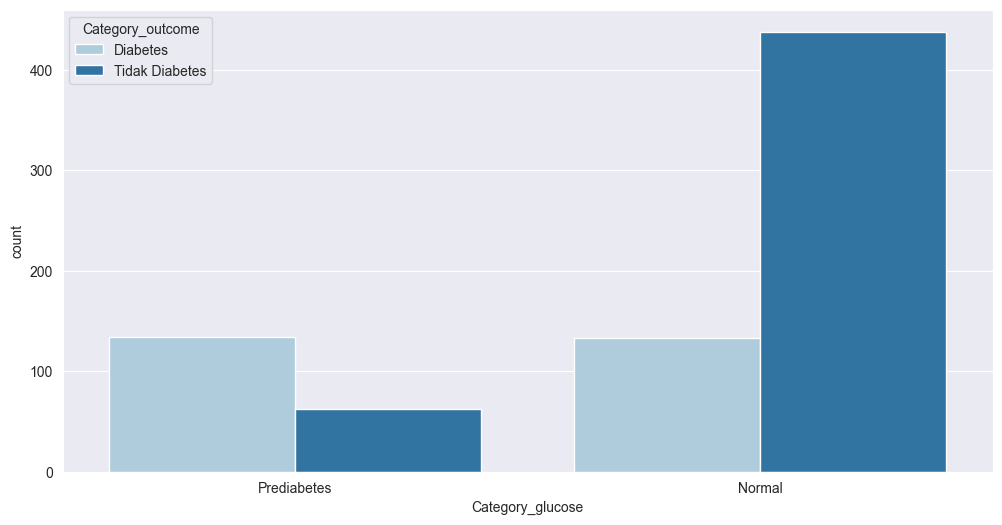

In [295]:
plt.figure(figsize=(12,6))

sns.countplot(df, x = 'Category_glucose', hue= 'Category_outcome', palette= 'Paired')

plt.show()

Dalam perbandingan antara pasien normal dan prediabetes ditemukan bahwa pasien yang termasuk dalam **prediabetes** banyak terkena **diabetes**.

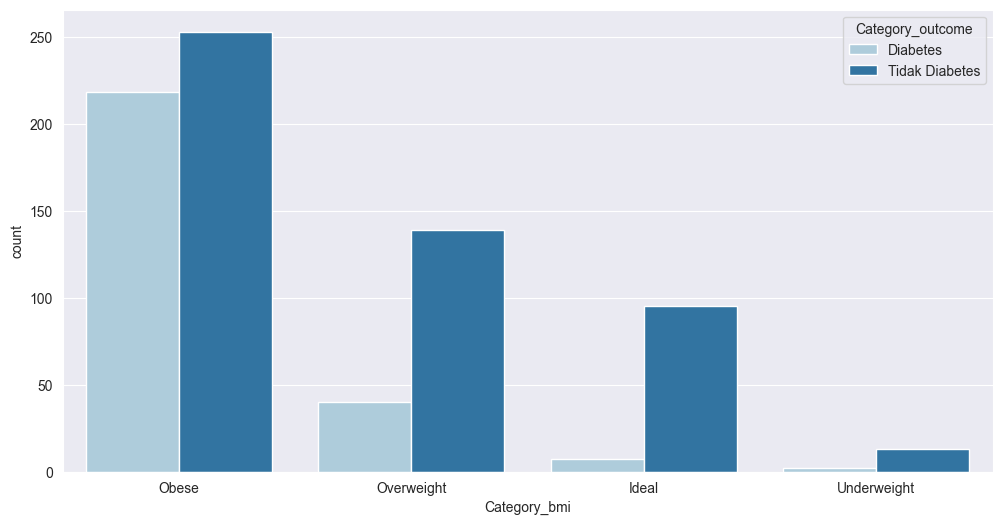

In [296]:
plt.figure(figsize=(12,6))

sns.countplot(df, x = 'Category_bmi', hue= 'Category_outcome', palette= 'Paired')

plt.show()

Dalam sisi BMI juga dapat diperhatikan bahwa rasio pasien yang terkena **diabetes** banyak diisi dari BMI yang **obesitas** dan **overweight**. Namun, tidak menutup kemnungkinan juga pasien yang termasuk ideal juga dapat mengalami diabetes.

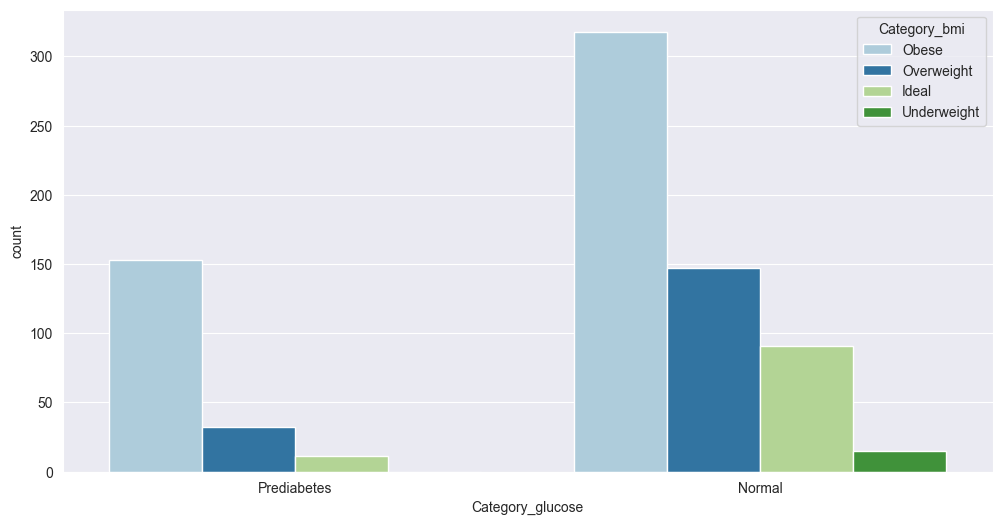

In [297]:
plt.figure(figsize=(12,6))

sns.countplot(df, x = 'Category_glucose', hue= 'Category_bmi', palette= 'Paired')

plt.show()

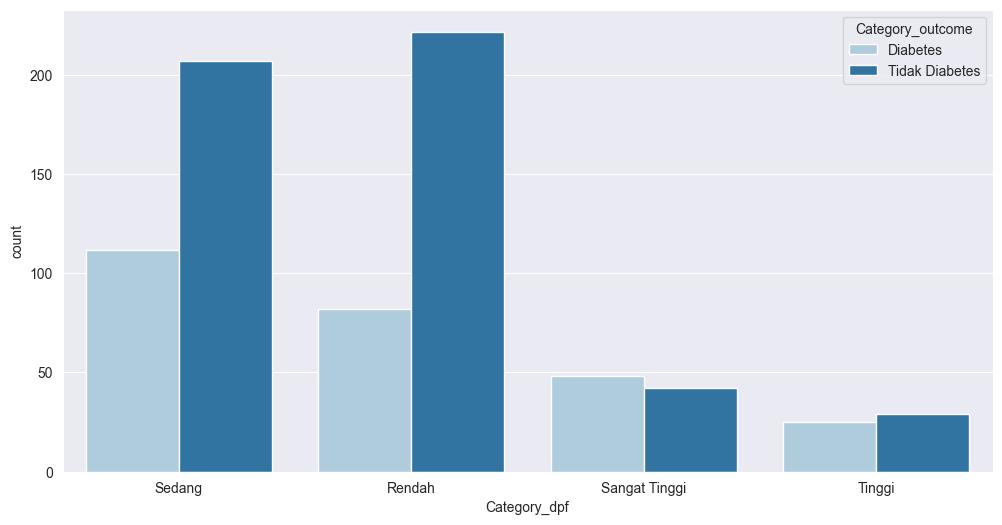

In [298]:
plt.figure(figsize=(12,6))

sns.countplot(df, x = 'Category_dpf', hue= 'Category_outcome', palette= 'Paired')

plt.show()

## Data Preparation

### Data Cleaning

#### Handling Missing Values

In [299]:
# Glucose, Blood Pressure, SkinThickness, BMI using Z-score (3-5)


In [300]:
# # # menghapus baris pada fitur yang memiliki data outlier 0

# # list fitur
# cols_to_impute = ['Glucose', 'BMI', 'BloodPressure', 'SkinThickness'] 

# # for i in list:
# #     df = df[df[i] != 0]
# # print('Data outlier 0 telah dihapus')
# df_original = df.copy()
# # ubah nilai 0 menjadi nan
# df[cols_to_impute] = df[cols_to_impute].replace(0, np.nan)

# df_missing = df.copy()

# errors = []

# K_values = range(1, 21)  # Coba K dari 1 sampai 20
# for k in K_values:
#     imputer = KNNImputer(n_neighbors=k)
#     df_imputed = df_missing.copy()
#     df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])
    
#     # Hitung error hanya untuk nilai yang awalnya missing (NaN)
#     mask = df_original[cols_to_impute].notna()
#     mse = mean_squared_error(df_original[cols_to_impute][mask], df_imputed[cols_to_impute][mask])
    
#     errors.append(mse)

# plt.figure(figsize=(8,5))
# plt.plot(K_values, errors, marker='o', linestyle='dashed')
# plt.xlabel('Number of Neighbors (K)')
# plt.ylabel('Mean Squared Error')
# plt.title('Elbow Method for Optimal K in KNN Imputer')
# plt.show()


In [301]:
# cols_to_impute = ['Glucose', 'BMI', 'BloodPressure', 'SkinThickness']
# df_impute = df.copy()

# # Pisahkan fitur dan target (jika ada target)
# df_original = df.copy()

# # Grid untuk nilai n_neighbors yang akan diuji
# n_neighbors_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# scores = []

# df_impute[cols_to_impute] = df[cols_to_impute].replace(0, np.nan)

# # Melakukan KNN Imputation untuk setiap nilai n_neighbors dan menghitung MSE
# for n_neighbors in n_neighbors_values:
#     knn_imputer = KNNImputer(n_neighbors=n_neighbors)
#     imputed_data = knn_imputer.fit_transform(df_original)
    
#     # Menghitung Mean Squared Error (MSE) antara data asli dan yang sudah diimputasi
#     mse = mean_squared_error(df_original, imputed_data)
#     scores.append(mse)

# # Visualisasi grafik MSE vs n_neighbors
# plt.figure(figsize=(8, 6))
# plt.plot(n_neighbors_values, scores, marker='o', linestyle='-', color='b')
# plt.title('MSE vs. n_neighbors', fontsize=14)
# plt.xlabel('n_neighbors', fontsize=12)
# plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
# plt.grid(True)
# plt.xticks(n_neighbors_values)
# plt.show()

In [302]:
# Misalkan 'df' adalah DataFrame kamu
columns_to_impute = ['Glucose', 'BMI', 'BloodPressure', 'SkinThickness']

# Ubah nilai 0 menjadi NaN di kolom yang ingin diimputasi
df[columns_to_impute] = df[columns_to_impute].replace(0, np.nan)

# Inisialisasi KNN Imputer (gunakan k=5 sebagai default)
imputer = KNNImputer(n_neighbors=5)

# Terapkan KNN Imputer hanya di kolom tertentu
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Cek apakah masih ada missing value
print(df[columns_to_impute].isnull().sum())

Glucose          0
BMI              0
BloodPressure    0
SkinThickness    0
dtype: int64


In [303]:
# Pregnancies, Insulin, DiabetesPedigreeFunction, Age using IQR (1.5-3).
# All outlier data values were rounded to the maximum value of the interval. (coerce)

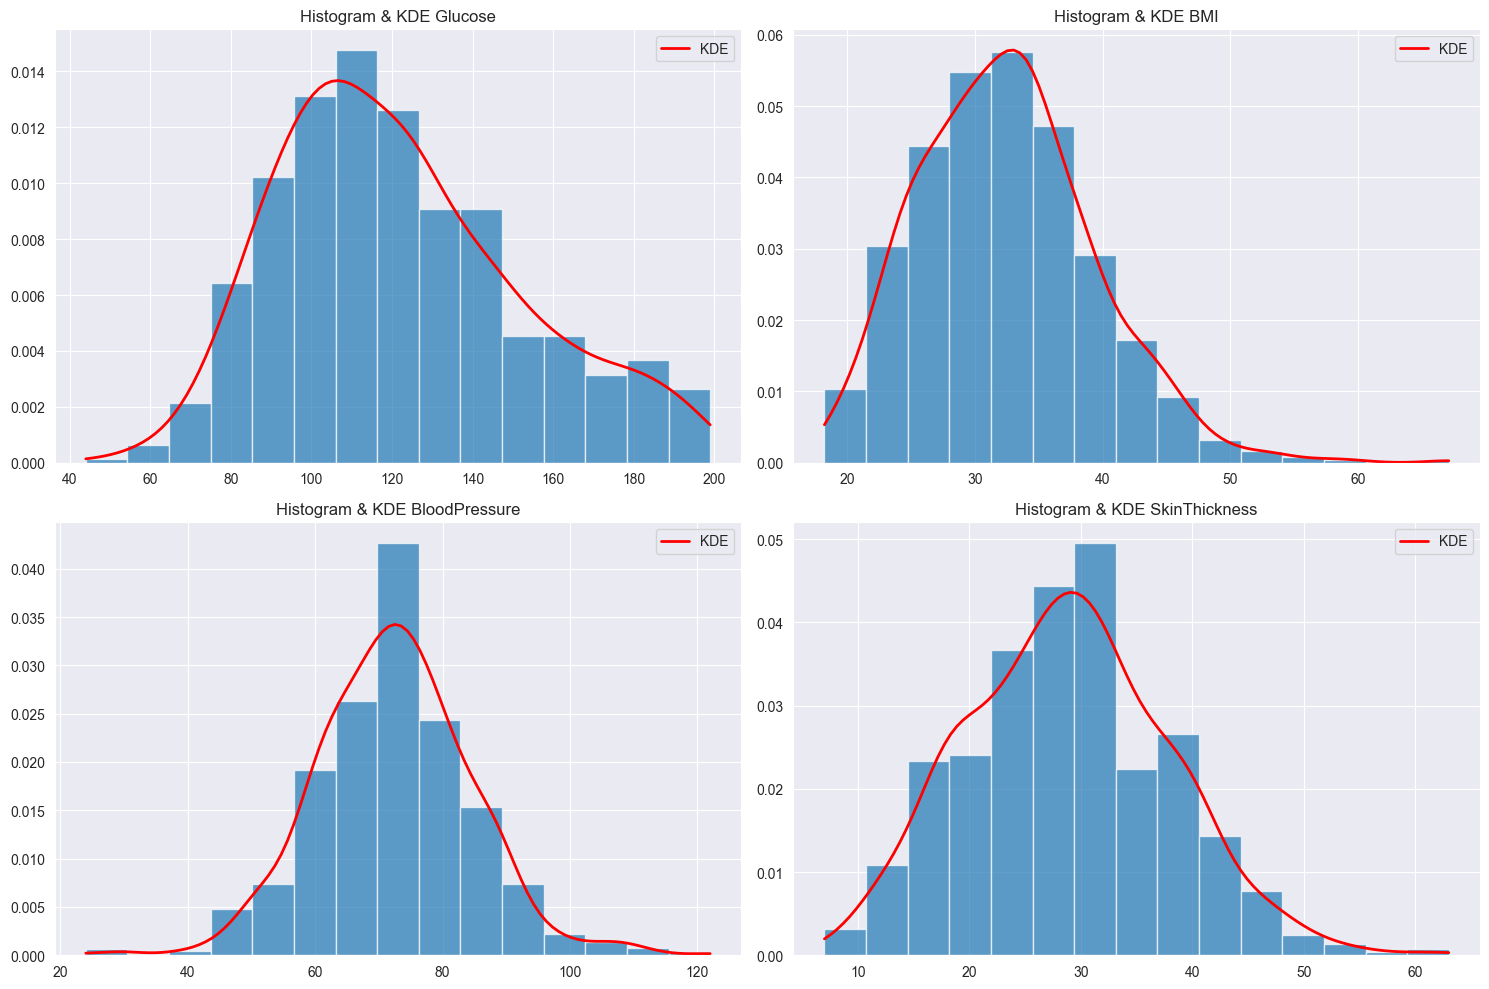

In [304]:
# Buat subplot dengan grid 1 kolom dan 3 baris dan atur figsize 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten() 
# Loop melalui fitur dan buat histogram di subplot masing-masing
# masukan parameter untuk fig dan axes (pada kasus ini adalah ax dan col)
for ax, col in zip(axes, columns_to_impute):
    # masukan fungsi histogram pada ax dan masukkan atributnya
    ax.hist(df[col], bins=15, alpha=0.7, density=True)
    

   # Estimasi KDE
    kde = gaussian_kde(df[col])
    x_vals = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(x_vals, kde(x_vals), color='red', lw=2, label='KDE')
    
    ax.set_title(f'Histogram & KDE {col}')
    ax.legend()


plt.tight_layout()
plt.show()

Ketiga fitur sudah tidak memiliki outlier nilai 0 seperti yang terlihat dari histogram plot.

#### Handling Outlier

In [305]:
# mengganti nilai mayoritas 0 pada insulin menggunakan median

median_value = df[df['Insulin'] != 0]['Insulin'].median()
# df['Insulin'] = df['Insulin'].replace(0, median_value)
print(median_value)

125.0


In [306]:
df['Insulin'].describe()

count    767.000000
mean      79.903520
std      115.283105
min        0.000000
25%        0.000000
50%       32.000000
75%      127.500000
max      846.000000
Name: Insulin, dtype: float64

In [307]:
# # Fungsi untuk mengganti nilai 0 dengan angka random di rentang 30-79
# def replace_zeros(value):
#     if value == 0:
#         return np.random.randint(48.0, 126.5)  # Rentang 48-125.5
#     return value

# # Fungsi untuk mengganti outlier (>400) dengan angka random di rentang 200-350
# def replace_outliers(value):
#     if value > 400:
#         return np.random.randint(200.0, 351.0)  # Rentang 200-350
#     return value

# # Terapkan perubahan
# df['Insulin'] = df['Insulin'].apply(replace_zeros)
# df['Insulin'] = df['Insulin'].apply(replace_outliers)

In [308]:
# Daftar fitur yang ingin diatasi outlier-nya
features = ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

# Fungsi untuk menangani outlier menggunakan IQR
def handle_outliers_iqr(df, features, iqr_multiplier=1.5):
    for feature in features:
        # Menghitung Q1 (kuartil pertama) dan Q3 (kuartil ketiga)
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        
        # Menghitung IQR
        IQR = Q3 - Q1
        
        # Menentukan batas bawah dan batas atas
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        # Membulatkan nilai outlier ke batas atas
        df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
        df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    
    return df

# Menggunakan fungsi untuk menangani outlier
df = handle_outliers_iqr(df, features)

Perubahan dilakukan untuk mengubah nilai **missing value (nilai 0)** dengan rentan **nilai yang ada pada Q2 dan median**. Hal ini dilakukan karena Q2 merepresenstasikan bagaimana nilai banyak terisi pada 50% data dan median merepresentasikan nilai tengah dari fitur insulin pada pasien, sehingga perubahan nila missing value pada hal ini bisa diterima, melihat kondisi missing value yang begitu banyak tidak masuk akal rasanya jika setengahnya pasien memiliki nilai insulin 0 pada tubuh mereka. Sehingga perubahan ini dilakukan agar nilai 0 pada fitur insulin bisa **merepresentasikan** sebagai **nilai normal rata-rata yang ada**.

Perubahan lain juga dilakuan pada **data outlier (data insulin > 400)**. Perubahan ini dilakukan karena banyaknya data ekstrem yang sangat jauh dari jangkauan batas atas (upper whisker) yang mengindikasikan bahwa data tersebut **mungkin memiliki kesalahan input atau memang memiliki kondisi tubuh yang berbeda** sehingga perlu ditinjau secara terpisah. Maka dari itu saya memutuskan untuk merubah nilai insulin > 400 dengan batas nilai indikasi resistensi insulin yaitu > 200 dengan batas atas quartil yaitu 350. Karena pada kasus ini volume pasien cukup banyak ditemukan pada rentan nilai tersebut, sehingga hal ini dapat mengurangi kesalahan dalam menghapus nilai real dari suatu individu.

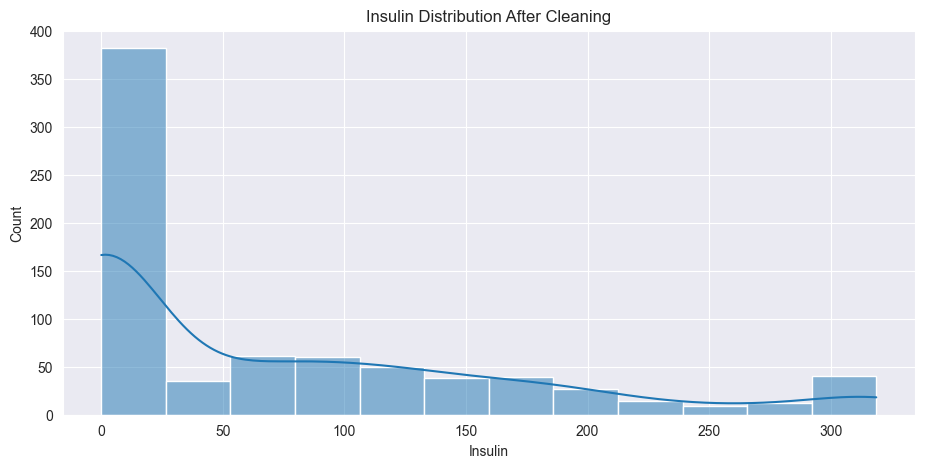

In [309]:
plt.figure(figsize=(11,5))
sns.histplot(data=df, x='Insulin', kde=True)
plt.title('Insulin Distribution After Cleaning')
plt.show()

In [310]:
# menggunakan iqr untuk melakukan handling outlier

# Q1 = df['Insulin'].quantile(0.25)
# Q3 =  df['Insulin'].quantile(0.75)

# # cari IQR
# IQR = Q3-Q1

# lower_bound = Q1 - (1.5 * IQR)
# upper_bound = Q3 + (1.5 * IQR)

# # Ganti outlier dengan batas atas/bawah
# df['Insulin'] = np.where(df['Insulin'] < lower_bound, lower_bound, df['Insulin'])
# df['Insulin'] = np.where(df['Insulin'] > upper_bound, upper_bound, df['Insulin'])

**Bivariate untuk insulin dan diabetes**

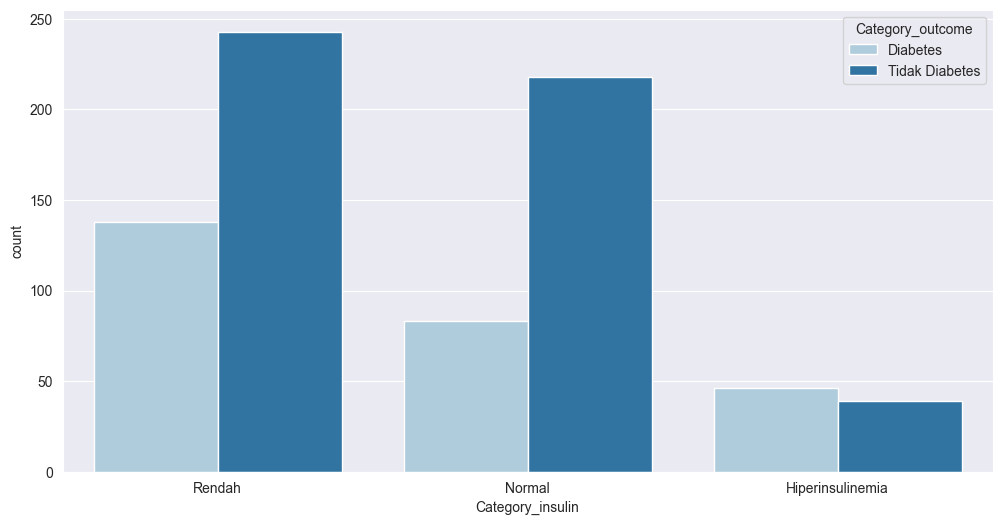

In [311]:
plt.figure(figsize=(12,6))

sns.countplot(df, x = 'Category_insulin', hue= 'Category_outcome', palette= 'Paired')

plt.show()

Menarik untuk diperhatikan bahwa dalam analisis biavariate ditemukan bahwa pasien yang termasuk kedalam **Hiperinsulinemia** memiliki **rasio terkena diabetes lebih banyak**. Selain itu juga dapat dilihat pada orang yang memiliki **insulin normal** juga cukup banyak ditemukan pasien yang mengalami **diabetes**. 

### Labelling

In [312]:
# melakukan label encoding pada data kategorikal

labelEncoding_cols = [
    'Category_bmi',
    'Category_glucose',
    'Category_dpf',
    'Category_insulin'
]

# buat fungsi labelEncoder
le = LabelEncoder()

# apply fungsi pada kolom yang ingin dilakukan labelEncoder
df[labelEncoding_cols] = df[labelEncoding_cols].apply(le.fit_transform)

In [313]:
# melihat value label dari setiap fitur
df[labelEncoding_cols].apply(pd.Series.value_counts)

,Category_bmi,Category_glucose,Category_dpf,Category_insulin
0,102,571.0,304,85.0
1,471,196.0,90,301.0
2,179,NaN,319,381.0
3,15,NaN,54,NaN


### Define Target

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               767 non-null    float64
 1   Glucose                   767 non-null    float64
 2   BloodPressure             767 non-null    float64
 3   SkinThickness             767 non-null    float64
 4   Insulin                   767 non-null    float64
 5   BMI                       767 non-null    float64
 6   DiabetesPedigreeFunction  767 non-null    float64
 7   Age                       767 non-null    float64
 8   Outcome                   767 non-null    int64  
 9   Category_outcome          767 non-null    object 
 10  Category_glucose          767 non-null    int32  
 11  Category_bmi              767 non-null    int32  
 12  Category_dpf              767 non-null    int32  
 13  Category_insulin          767 non-null    int32  
dtypes: float64

In [315]:
# tentukan variabel untuk train
X = df.drop(columns=[

    # fitur yang tidak dibutuhkan
    'BMI',
    'Glucose',
    'DiabetesPedigreeFunction',
    'Insulin',

    # variabel target
    'Outcome',

    # katgorik yang tidak diperlukan
    'Category_outcome',
    # 'Category_insulin',
    # 'Category_bmi', 
    # 'Category_dpf',
    # 'Category_glucose'
])

# variabel target
y = df['Outcome']

### Sampling

In [316]:
oversampling = SMOTE(random_state=12, sampling_strategy=1)
X, y = oversampling.fit_resample(X,y)

In [317]:
y.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               767 non-null    float64
 1   Glucose                   767 non-null    float64
 2   BloodPressure             767 non-null    float64
 3   SkinThickness             767 non-null    float64
 4   Insulin                   767 non-null    float64
 5   BMI                       767 non-null    float64
 6   DiabetesPedigreeFunction  767 non-null    float64
 7   Age                       767 non-null    float64
 8   Outcome                   767 non-null    int64  
 9   Category_outcome          767 non-null    object 
 10  Category_glucose          767 non-null    int32  
 11  Category_bmi              767 non-null    int32  
 12  Category_dpf              767 non-null    int32  
 13  Category_insulin          767 non-null    int32  
dtypes: float64

In [319]:
# membagi data train dan tes menggunakan train_test_split dengan perbaningan 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

# buat fungsi untuk melakukan standarisasi pada data
scaler =  StandardScaler()

# standarisasi data pada train_test_split
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Data Modelling

In [320]:
# inisiasi untuk model yang akan digunakan
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=800),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=500),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
}

In [321]:
#  Evaluasi Model dengan Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}


for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, 
                            scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], 
                            return_train_score=False)
    
    results[name] = {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision_macro'].mean(),
        'f1_score' : scores['test_f1_macro'].mean(),
        'recall': scores['test_recall_macro'].mean()
    }

    # **8. Print Hasil Evaluasi**
    print(f'Model {name} Scores:')
    print(f" Accuracy : {results[name]['accuracy']:.4f}")
    print(f" Precision : {results[name]['precision']:.4f}")
    print(f" F1_score : {results[name]['f1_score']:.4f}")
    print(f" Recall : {results[name]['recall']:.4f}")
    # print("-"*40)

Model Decision Tree Scores:
 Accuracy : 0.6663
 Precision : 0.6690
 F1_score : 0.6648
 Recall : 0.6663
Model Random Forest Scores:
 Accuracy : 0.7513
 Precision : 0.7536
 F1_score : 0.7505
 Recall : 0.7513
Model XGBoost Scores:
 Accuracy : 0.7412
 Precision : 0.7432
 F1_score : 0.7407
 Recall : 0.7412
Model AdaBoost Scores:
 Accuracy : 0.7100
 Precision : 0.7110
 F1_score : 0.7096
 Recall : 0.7100


Terlihat pada hasil evaluasi model, XGboost dan Random Forest memiliki performa yang baik dibandingkan dengan model lainnya dengan akurasi 74% dan 75%. Tetapi untuk melihat hasil model kita perlu melakukan evaluasi yang lanjut terkait seberapa baik model dalam melakukan prediksi.

## Evaluation

### Confusion Matrix

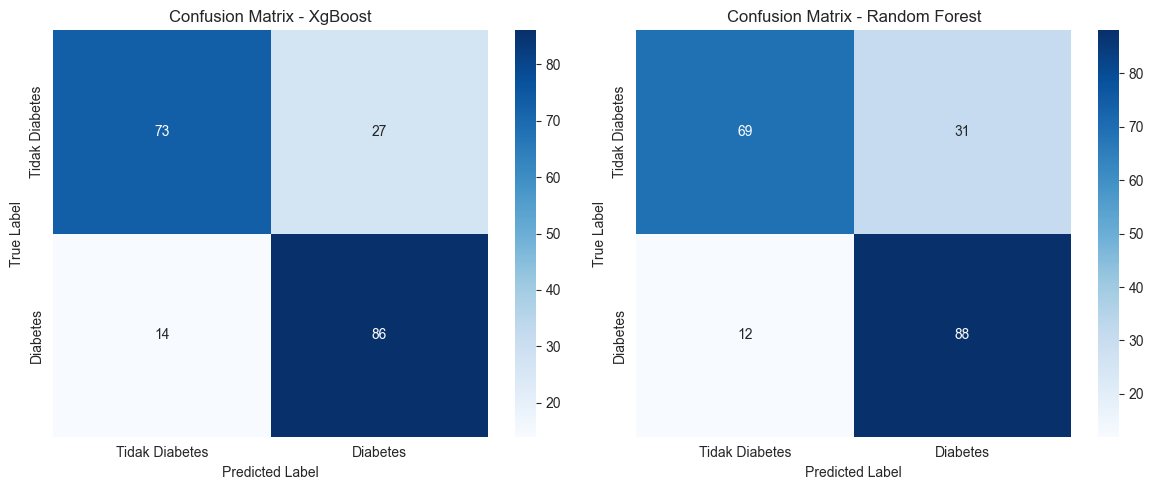

In [322]:
# Ambil model dari dictionary
XGbst_model = models["XGBoost"]
rf_model = models["Random Forest"]

# # **Latih model dulu**
rf_model.fit(X_train, y_train)

# **Latih model dulu sebelum prediksi**
XGbst_model.fit(X_train, y_train)


# **Lakukan prediksi**
y_pred_xgbst = XGbst_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# **Buat confusion matrix**
cm_xbgst = confusion_matrix(y_test, y_pred_xgbst)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# **Plot confusion matrix**
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_xbgst, annot=True, fmt="d", cmap="Blues", xticklabels=["Tidak Diabetes", "Diabetes"], yticklabels=["Tidak Diabetes", "Diabetes"], ax=axes[0])
axes[0].set_title("Confusion Matrix - XgBoost")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Tidak Diabetes", "Diabetes"], yticklabels=["Tidak Diabetes", "Diabetes"], ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

Dari hasil confusion matrix terlihat bahwa kedua model mampu memberikan hasil prediksi yang lumayan bagus pada diagnosa pasien tidak diabetes dan diabetes. Namun, keduanya masih memberikan nilai **false positive** (model salah memprediksi "Diabetes" padahal seharusnya "Tidak Diabetes") yang cukup tinggi. Dalam melakukan diagnosa medis, hal seperti ini memerlukan hasil seminimum mungkin karena efeknya akan sangat berpengaruh pada pasien. Maka dari itu hasil dari model ini masih mungkin untuk dapat ditingkatkan dengan hypertuning atau algoritma model yang lebih kompleks.

### ROC Curve & Precision-Recall Curve

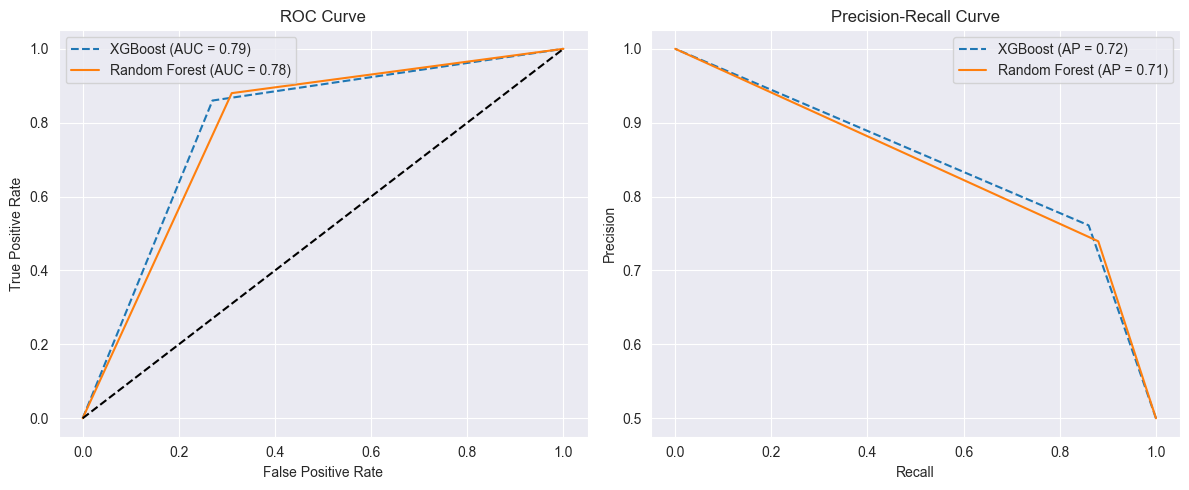

In [323]:
def plot_curves(y_test, y_probs_xgb, y_probs_rf):
    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
    
    auc_xgb = auc(fpr_xgb, tpr_xgb)
    auc_rf = auc(fpr_rf, tpr_rf)
    
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linestyle='--')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle='-')

    plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal sebagai baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_probs_xgb)
    precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)

    ap_xgb = average_precision_score(y_test, y_probs_xgb)
    ap_rf = average_precision_score(y_test, y_probs_rf)

    plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f})', linestyle='--')
    plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.2f})', linestyle='-')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(y_test, y_pred_xgbst, y_pred_rf)

**ROC Curve**

Nilai AUC 0.79 dan 0.78 menunjukkan bahwa kedua model memiliki kemampuan yang cukup baik dalam membedakan antara kelas "Diabetes" dan "Tidak Diabetes". Kurva keduanya hampir identik, menandakan performa serupa dalam hal trade-off antara True Positive Rate (TPR) dan False Positive Rate (FPR). Model dengan AUC 0.79 bisa dianggap cukup baik, tetapi masih ada ruang untuk peningkatan.

**Precision-Recall Curve**

Nilai AP 0.72 dan 0.71 menunjukkan bahwa model memiliki performa yang lumayan dalam menjaga keseimbangan antara precision dan recall. Model memiliki trade-off antara precision dan recall yang cukup baik, tetapi jika ingin meningkatkan recall tanpa terlalu mengorbankan precision, mungkin perlu menyesuaikan threshold prediksi.

### Feature Importance

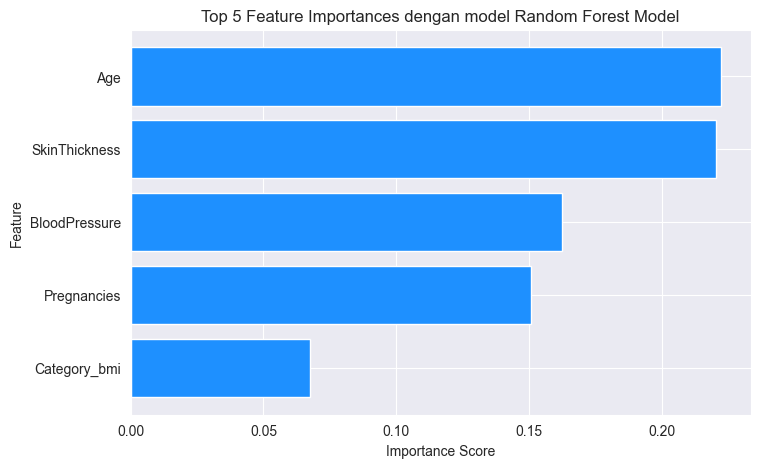

In [324]:
# melihat feature importance
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# memilih top 5 features
top_5_features = feature_importance_df.head(5)

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='dodgerblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances dengan model Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()